## 4	OBTENIENDO Y PROCESANDO DATOS FINANCIEROS

## 4.1	 Obteniendo datos de Yahoo Finance

In [ ]:
#1.Importar librerías

import pandas as pd
import yfinance as yf 

#2.Descargar los datos

df_yahoo = yf.download('AAPL',
         start='2010-01-01', end='2020-11-30', progress=False) 

#3.Mostrar los resultados

df_yahoo

## 4.2	 Obteniendo datos de Quandl

In [ ]:
#1.Importar librerías

import pandas as pd
import quandl

#2.Autentíquese con la clave API personal:

QUANDL_API_KEY = 'API key'  
quandl.ApiConfig.api_key = QUANDL_API_KEY
#Necesita reemplazar {key} con su propia clave API.

#3.Descargar los datos:

df_quandl = quandl.get(dataset='WIKI/AAPL',
                       start_date='2010-01-01',
                       end_date='2020-11-30')


## 4.3 Obteniendo datos de Intrinio

In [ ]:
#1.Importar librerias

import intrinio_sdk 
import pandas as pd

#2.Autenticar usando la clave API personal. Debe reemplazar ['api_key'] por su propia clave API.

intrinio_sdk.ApiClient().configuration.api_key['api_key'] = 'api_key' 

security_api = intrinio_sdk.SecurityApi()

#3.Solicitar los datos

r = security_api.get_security_stock_prices(identifier='AAPL', 
start_date='2010-01-01', 
end_date='2020-11-30', 
frequency='daily', 
page_size=10000)

#4.Convertir los resultados en un DataFrame:

response_list = [x.to_dict() for x in r.stock_prices] 
df_intrinio = pd.DataFrame(response_list).sort_values('date') 
df_intrinio.set_index('date', inplace=True)

#5.Mostrar los resultados

df_intrinio


## 4.4	Transformando precios de activos financieros a rendimientos

In [3]:
#1.Importar librerías

import pandas as pd 
import numpy as np 
import yfinance as yf

#2.Descargue los datos y mantenga solo los precios de cierre ajustados:

df = yf.download('AAPL', 
start='2010-01-01', 
end='2020-11-30', 
progress=False) 
df = df.loc[:, ['Adj Close']] 
df.rename(columns={'Adj Close':'adj_close'}, inplace=True)

#3.Calcule los rendimientos simples y log utilizando los precios de cierre ajustados:

df['simple_rtn'] = df.adj_close.pct_change() 
df['log_rtn'] = np.log(df.adj_close/df.adj_close.shift(1))

#4.Mostrar los resultados

df



adj_close  simple_rtn   log_rtn
Date                                        
2010-01-04    6.572422         NaN       NaN
2010-01-05    6.583784    0.001729  0.001727
2010-01-06    6.479061   -0.015906 -0.016034
2010-01-07    6.467082   -0.001849 -0.001851
2010-01-08    6.510078    0.006648  0.006626
...                ...         ...       ...
2020-11-20  116.966240   -0.010958 -0.011018
2020-11-23  113.487358   -0.029743 -0.030194
2020-11-24  114.803154    0.011594  0.011528
2020-11-25  115.660416    0.007467  0.007439
2020-11-27  116.218628    0.004826  0.004815

[2746 rows x 3 columns]

In [ ]:
#1.Importar librerías y autenticarse

import pandas as pd
import numpy as np
import yfinance as yf
import quandl

#2.Reemplace {key}con su propia API key de Quandl

QUANDL_API_KEY = '{key}'
quandl.ApiConfig.api_key = QUANDL_API_KEY

#3.Descargar los precios de cierre ajustados para el período 2010-2020

df = yf.download('AAPL',
                 start='2010-01-01',
                 end='2020-11-30',
                 progress=False)
df = df.loc[:, ['Adj Close']]
df.rename(columns={'Adj Close':'adj_close'}, inplace=True)


#4.Calcula los rendimientos simples y logaritmicos

df['simple_rtn'] = df.adj_close.pct_change()
df['log_rtn'] = np.log(df.adj_close/df.adj_close.shift(1))


#5.Crear un DataFrame con la unión de las fechas (a la izquierda) y los precios de cierre a la derecha

df_all_dates = pd.DataFrame(index=pd.date_range(start='2009-12-31',
                                                end='2020-11-30'))
df = df_all_dates.join(df[['adj_close']], how='left') \
                 .fillna(method='ffill') \
                 .asfreq('M')


#6.Descargue los datos de inflación de Quandl:

df_cpi = quandl.get(dataset='RATEINF/CPI_USA', 
start_date='2009-12-01', 
end_date='2020-11-30') 
df_cpi.rename(columns={'Value':'cpi'}, inplace=True)


#7.Combinar los datos de inflación con los precios:

df_merged = df.join(df_cpi, how='left')

#8.Calcule los rendimientos simples y la tasa de inflación:

df_merged['simple_rtn'] = df_merged.adj_close.pct_change() 
df_merged['inflation_rate'] = df_merged.cpi.pct_change()


#9.Ajuste los rendimientos por inflación:

df_merged['real_rtn'] = (df_merged.simple_rtn + 1) / (df_merged.inflation_rate + 1) – 1

#10.Mostrar los resultados

df.merged



## 4.5	Cambiando la frecuencia temporal de los rendimientos

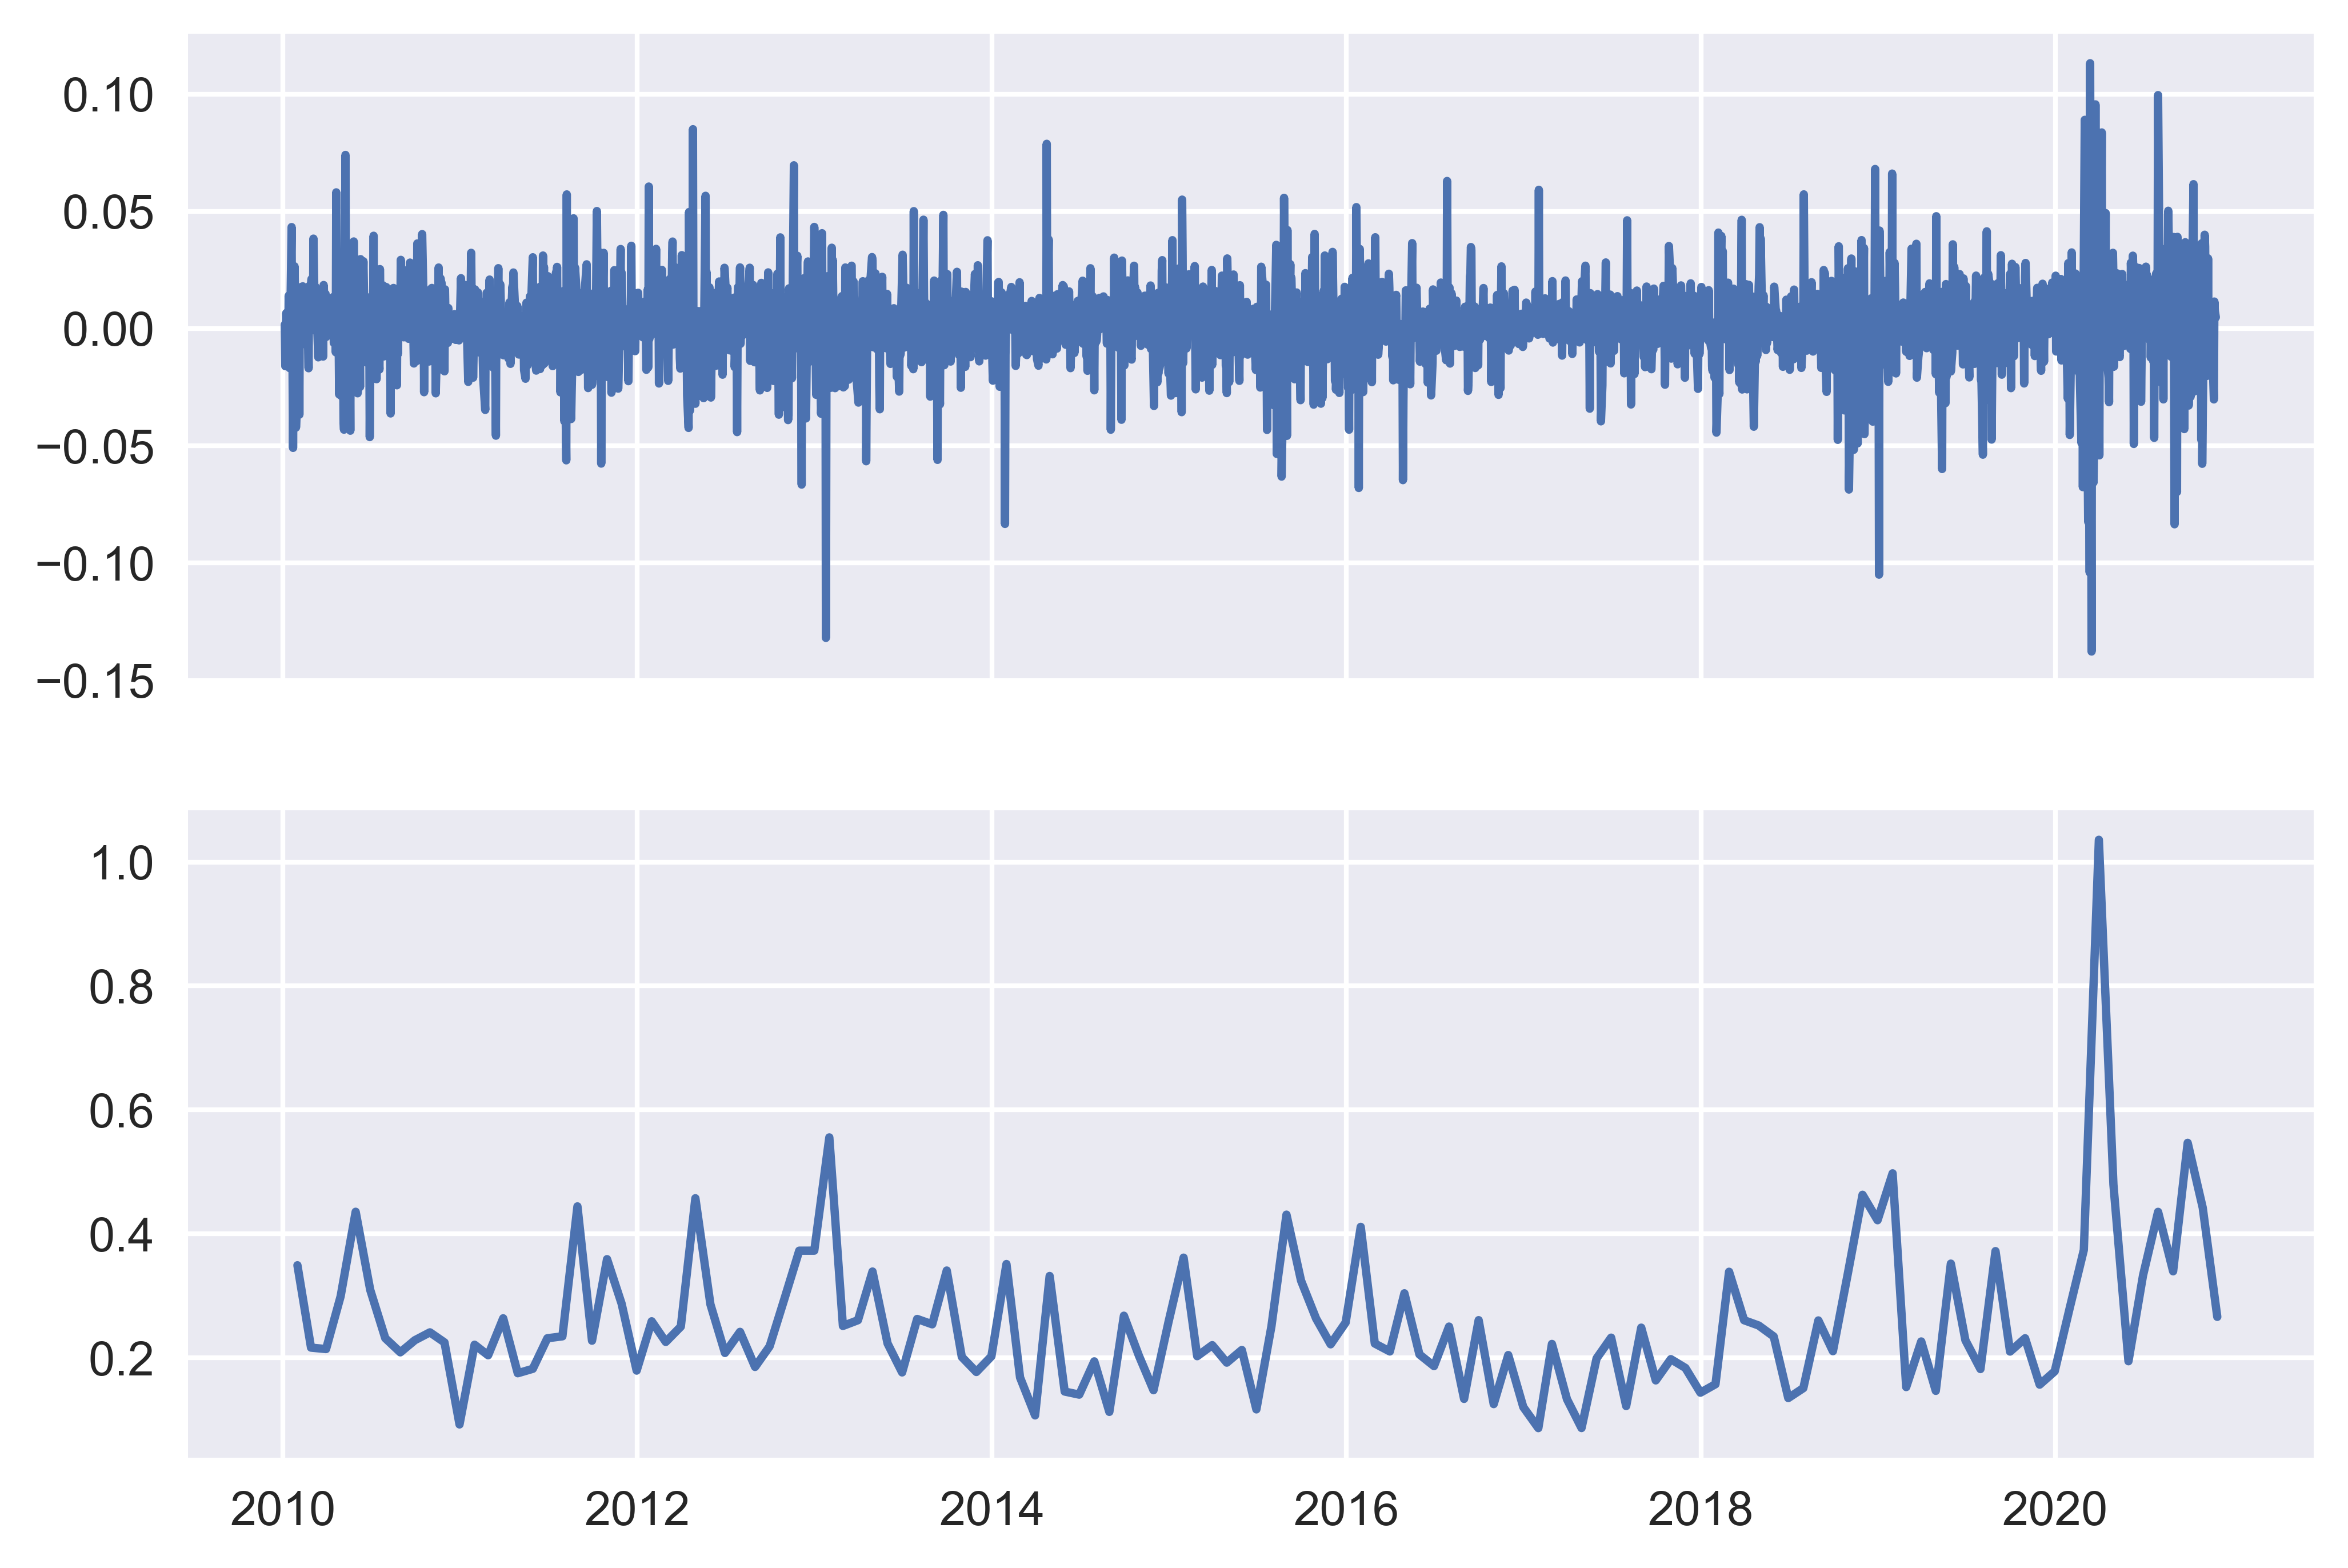

In [5]:
#1.Importar las librerías requeridas

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd 
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import warnings

#2. Definir estilo del gráfico y control mensajes de advertencia 

plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
# plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

#3. Descargar los datos 

df = yf.download('AAPL', 
                 start='2010-01-01', 
                 end='2020-11-30', 
                 auto_adjust=False,
                 progress=False)

# 4.Guardar solamente el precio de cierre ajustado

df = df.loc[:, ['Adj Close']]
df.rename(columns={'Adj Close': 'adj_close'}, inplace=True)

# 5.Calcular los rendimientos simples

df['log_rtn'] = np.log(df.adj_close/df.adj_close.shift(1))

#6. Eliminar datos redundantes

df.drop('adj_close', axis=1, inplace=True)
df.dropna(axis=0, inplace=True)


#7. Definir la función para calcular la volatilidad realizada


def realized_volatility(x):
    return np.sqrt(np.sum(x**2))

# 8.Calcular la volatilidad realizada mensual


df_rv = df.groupby(pd.Grouper(freq='M')).apply(realized_volatility)
df_rv.rename(columns={'log_rtn': 'rv'}, inplace=True)


#9. Anualizar los valores

df_rv.rv = df_rv.rv * np.sqrt(12)

# 10.Graficar los resultados

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(df)
ax[1].plot(df_rv)

# plt.tight_layout()
# plt.savefig('images/ch1_im6.png')
plt.show()



## 4.6	 Visualizando datos de series de tiempo financieras

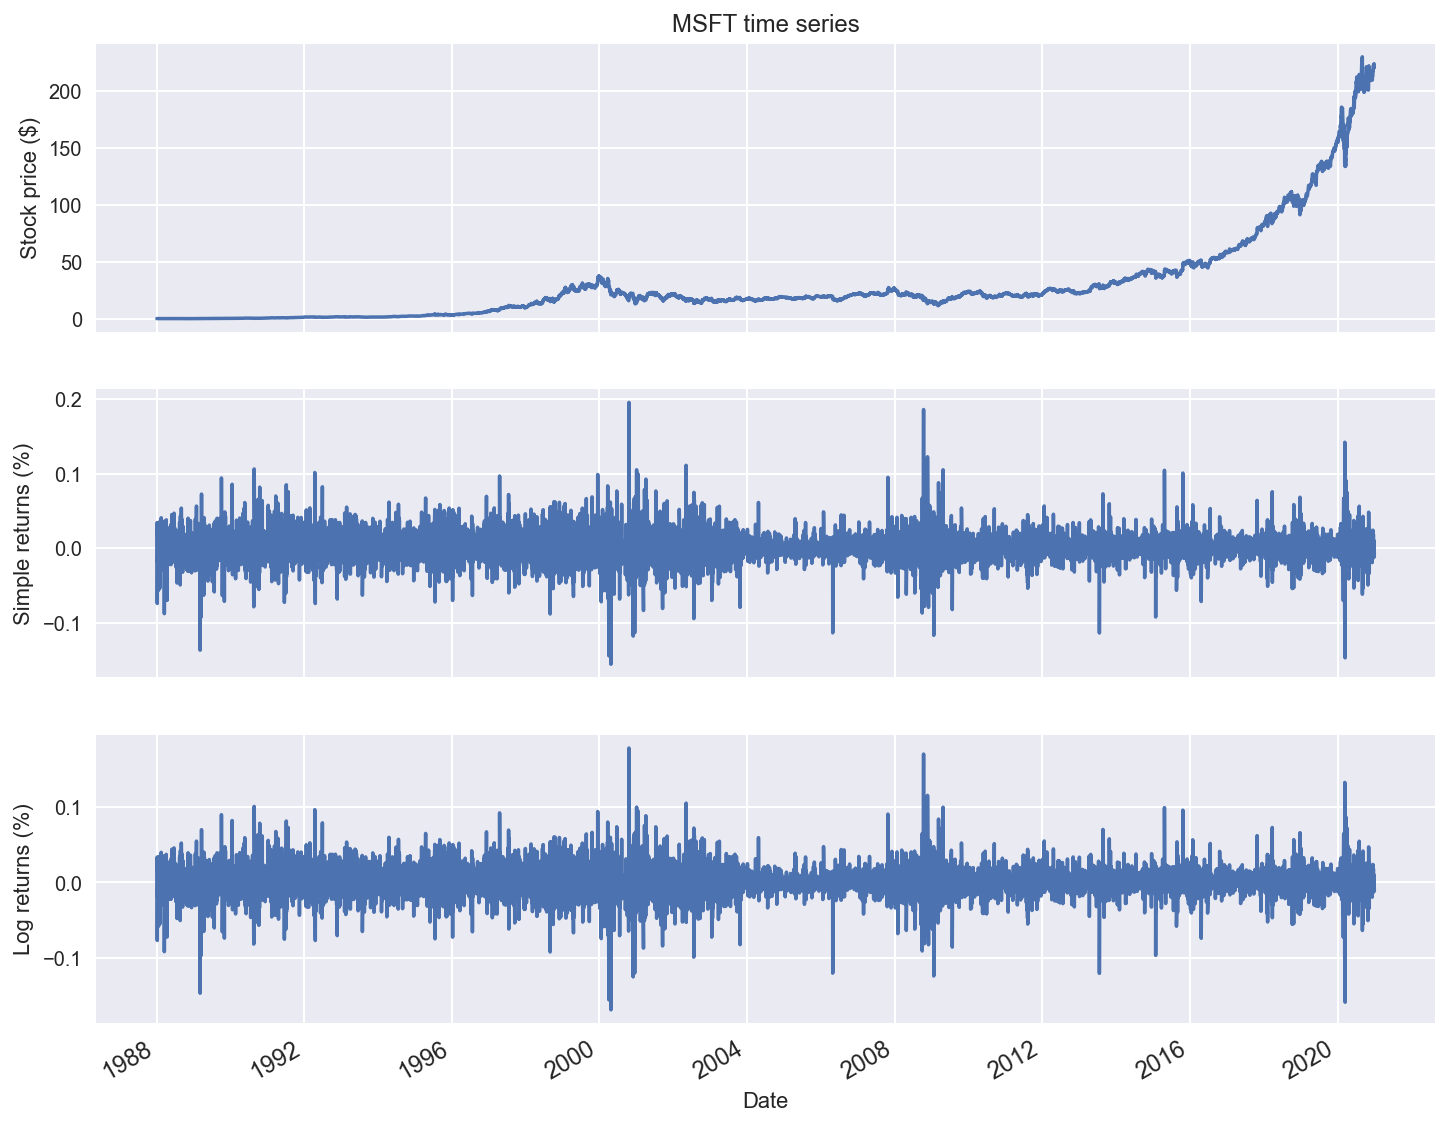

In [6]:
#1.Importar librerias

import pandas as pd 
import numpy as np 
import yfinance as yf

#2.Descargar los datos y mantener solo los precios de cierre ajustados:

df = yf.download('MSFT', 
start='1988-01-01', 
end='2020-12-31', 
progress=False) 
df = df.loc[:, ['Adj Close']] 
df.rename(columns={'Adj Close':'adj_close'}, inplace=True)

#3.Calcular los rendimientos simples y logarítmico utilizando los precios de cierre ajustados:

df['simple_rtn'] = df.adj_close.pct_change() 
df['log_rtn'] = np.log(df.adj_close/df.adj_close.shift(1))

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#4.Importar librerías

import matplotlib.pyplot as plt
import warnings

fig, ax = plt.subplots(3, 1, figsize=(12, 10), sharex=True)


#5.Agregar precios

df.adj_close.plot(ax=ax[0])
ax[0].set(title = 'MSFT time series',
          ylabel = 'Stock price ($)')


#6.Agregar rendimientos simples

df.simple_rtn.plot(ax=ax[1])
ax[1].set(ylabel = 'Simple returns (%)')

#7.Agregar rendimientos logarítmicos y graficar

df.log_rtn.plot(ax=ax[2])
ax[2].set(xlabel = 'Date', 
          ylabel = 'Log returns (%)')

ax[2].tick_params(axis='x', 
                  which='major', 
                  labelsize=12)

# plt.tight_layout()
# plt.savefig('images/ch1_im7.png')
plt.show()



In [7]:
#1.Importar librerias

import pandas as pd 
import numpy as np 
import yfinance as yf

#2.Descargue los datos y mantenga solo los precios de cierre ajustados:

df = yf.download('MSFT', 
start='1988-01-01', 
end='2020-12-31', 
progress=False) 
df = df.loc[:, ['Adj Close']] 
df.rename(columns={'Adj Close':'adj_close'}, inplace=True)

#3.Calcule los rendimientos simples y log utilizando los precios de cierre ajustados:

df['simple_rtn'] = df.adj_close.pct_change() 
df['log_rtn'] = np.log(df.adj_close/df.adj_close.shift(1))

#4.Importar las librerías y manejar la configuración:

%matplotlib inline
import plotly.graph_objs as go
from  plotly.offline import plot
import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline()
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
init_notebook_mode(connected='true')

#5.Crear el gráfico

df.iplot(subplots=True, shape=(3,1), shared_xaxes=True, title='MSFT time series')



## 4.7	Identificando valores atípicos en la serie temporal

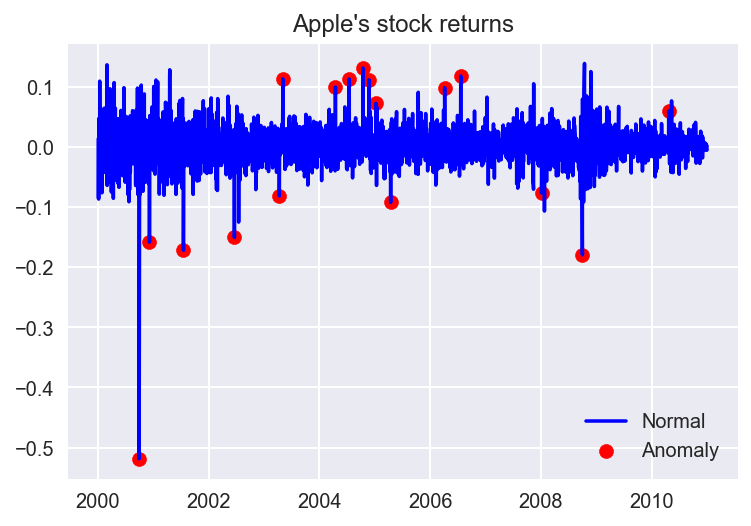

In [8]:
#1. Importe las librerías requeridas

import pandas as pd 
import yfinance as yf

#2. Descargue los datos y mantenga solo los precios de cierre ajustados:

df = yf.download('AAPL', 
                 start='2000-01-01', 
                 end='2010-12-31',
                 progress=False)

df = df.loc[:, ['Adj Close']]
df.rename(columns={'Adj Close':'adj_close'}, inplace=True)

# 3.Convierta los precios de cierre ajustados a rendimientos simples

df['simple_rtn'] = df.adj_close.pct_change()

#4.Calcule la media móvil y la desviación estandar:

df_rolling = df[['simple_rtn']].rolling(window=21) \
                               .agg(['mean', 'std'])
df_rolling.columns = df_rolling.columns.droplevel()

#5.Unir las medias móviles a los datos originales:

df_outliers = df.join(df_rolling)

#6.Defina una función para detectar valores atípicos:
def indentify_outliers(row, n_sigmas=3):
    '''
    Function for identifying the outliers using the 3 sigma rule. 
    The row must contain the following columns/indices: simple_rtn, mean, std.
    
    Parameters
    ----------
    row : pd.Series
        A row of a pd.DataFrame, over which the function can be applied.
    n_sigmas : int
        The number of standard deviations above/below the mean - used for detecting outliers
        
    Returns
    -------
    0/1 : int
        An integer with 1 indicating an outlier and 0 otherwise.
    '''
    x = row['simple_rtn']
    mu = row['mean']
    sigma = row['std']
    
    if (x > mu + 3 * sigma) | (x < mu - 3 * sigma):
        return 1
    else:
        return 0

#7.Identifique los valores atípicos y extraiga sus valores para su uso posterior:

df_outliers['outlier'] = df_outliers.apply(indentify_outliers, 
                                           axis=1)
outliers = df_outliers.loc[df_outliers['outlier'] == 1, 
                           ['simple_rtn']]

#8.Grafique los resultados:
fig, ax = plt.subplots()

ax.plot(df_outliers.index, df_outliers.simple_rtn, 
        color='blue', label='Normal')
ax.scatter(outliers.index, outliers.simple_rtn, 
           color='red', label='Anomaly')
ax.set_title("Apple's stock returns")
ax.legend(loc='lower right')

# plt.tight_layout()
# plt.savefig('images/ch1_im9.png')
plt.show()




## 4.8	Obtención y remuestreo de datos sobre criptomonedas

## 4.8.1	Obteniendo los datos de Kraken (Exchanges)

In [ ]:
import requests
import pandas as pd

endpoint = 'https://api.kraken.com/0/public/Trades'
payLoad = {'pair': 'XETHZUSD'}
response = requests.get(url=endpoint, params=payLoad)
tradeData = response.json()
trades = tradeData['result']['XETHZUSD']

trades[:5]

In [ ]:
tradesDF = pd.DataFrame.from_records(trades,                                    
columns=['Price','Volume','Time','BuySell','MarketLimit','Misc'])
tradesDF


In [ ]:
tradesDF['Time'] = pd.to_datetime(tradesDF['Time'], unit='s')
tradesDF.set_index('Time',inplace=True)

tradesDF


In [23]:
tradeData["result"]["last"]

'1625254696040824054'

In [24]:
pd.to_datetime(int(tradeData["result"]["last"]),unit="ns")

Timestamp('2021-07-02 19:38:16.040824054')

In [25]:
import requests
import pandas as pd
import datetime
from datetime import timezone
import time

def getKrakenTradeData(pair, startDate, endDate):
    endpoint = 'https://api.kraken.com/0/public/Trades'
    
    startTime = int(datetime.datetime.strptime(startDate, '%Y-%m-%d').replace(tzinfo=timezone.utc).timestamp()*1000000000)
    endTime = int(datetime.datetime.strptime(endDate, '%Y-%m-%d').replace(tzinfo=timezone.utc).timestamp()*1000000000)
    
    timeLoaded = startTime
    
    result = pd.DataFrame()
    
    while timeLoaded < endTime:
        print(pd.to_datetime(timeLoaded, unit='ns').strftime('%Y-%m-%d %H:%M:%S'))
        payLoad = {'pair': pair,
                   'since': timeLoaded}
        
        response = requests.get(url=endpoint, params=payLoad)
        data = response.json()['result']
        tradesRaw = data[pair]
        timeLoaded = int(data["last"])
        
        tradeData = pd.DataFrame.from_records(tradesRaw,
                             columns=['Price', 'Volume', 'Time', 'BuySell', 'MarketLimit', 'Misc'])
        tradeData['Time'] = pd.to_datetime(tradeData['Time'], unit='s')
        
        result = result.append(tradeData)
        
        time.sleep(3)
        
    result.set_index("Time", inplace = True)
    result = result.loc[startDate:endDate+' 00:00:00']
    
    return result


In [26]:
trades

[['2093.26000', '0.60045317', 1625249533.6007, 'b', 'm', ''],
 ['2093.26000', '5.39454683', 1625249533.6022, 'b', 'm', ''],
 ['2093.27000', '4.60545317', 1625249533.6031, 'b', 'm', ''],
 ['2092.97000', '0.01724683', 1625249544.8276, 'b', 'm', ''],
 ['2092.96000', '0.32984870', 1625249550.0914, 's', 'm', ''],
 ['2092.00000', '0.02271968', 1625249574.8484, 'b', 'm', ''],
 ['2093.64000', '0.94711878', 1625249604.8325, 's', 'l', ''],
 ['2093.64000', '0.00245612', 1625249604.8334, 's', 'l', ''],
 ['2093.64000', '0.00000637', 1625249604.8342, 's', 'l', ''],
 ['2093.64000', '0.00000002', 1625249604.8349, 's', 'l', ''],
 ['2093.43000', '0.27800000', 1625249610.8583, 's', 'l', ''],
 ['2093.43000', '0.06522538', 1625249610.8596, 's', 'l', ''],
 ['2093.16000', '0.09800000', 1625249611.5897, 'b', 'l', ''],
 ['2092.88000', '0.01289922', 1625249616.3892, 's', 'm', ''],
 ['2093.00000', '0.18747092', 1625249650.7687, 's', 'l', ''],
 ['2093.00000', '1.01648979', 1625249650.8897, 's', 'l', ''],
 ['2093.

## 4.8.2	Remuestreo

In [ ]:
tradesDF.resample('1H')['Price'].agg(['first'])

